In [46]:
import torch
import numpy as np
from PIL import Image
import IPython.display as ipd
from torchvision.transforms import v2
from module.model_builder.model import Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoints = torch.load("checkpoints2/pre3.pth.tar", map_location=device)
vocab = checkpoints['vocab']
transform = v2.Compose([
    v2.PILToTensor(),
    v2.ToDtype(torch.float)
])
# Create instance model
n_dim_model = 256
# --- Encoder Parameters ---
input_chanel_encoder = 3
hidden_dim_encoder = 256
n_head_encoder = 8
n_expansion_encoder = 8
n_layer_encoder = 6
# --- Decoder Parameters ---
n_head_decoder = 8
seq_length_decoder = 224
vocab_size_decoder = len(vocab)
n_expansion_decoder = 8
n_layer_decoder = 6
model = Model(n_dim_model, input_chanel_encoder, hidden_dim_encoder, n_head_encoder, n_expansion_encoder, n_layer_encoder,
              n_head_decoder, seq_length_decoder, vocab_size_decoder, n_expansion_decoder, n_layer_decoder).to(device)
model.load_state_dict(checkpoints['model_state_dict'])

<All keys matched successfully>

In [47]:
def resize_image(image, height=32):
    w, h = image.size
    ratio = height / h
    new_width = int(w * ratio)
    new_width = np.ceil(new_width / 32) * 32
    processed_image = image.resize((int(new_width), height))
    return processed_image

def pre_process(image):
    image = resize_image(image)
    background = Image.new('RGB', (1600, 32))
    background.paste(image, (0, 0))
    return background

def inference(image: Image, model: Model, vocab):
    v = list(vocab.keys())
    idx_start = vocab['<start>']
    idx_end = vocab['<end>']
    model.eval()
    with torch.no_grad():
        labels = [idx_start]
        # Encoder
        input_encoder = transform(image)
        input_encoder = input_encoder.unsqueeze(0).to(device)
        for _ in range(seq_length_decoder):
            # Decoder
            input_decoder = torch.Tensor(labels).int()
            input_decoder = torch.unsqueeze(input_decoder, 0).to(device)
            output = model(input_encoder, input_decoder)
            idx = torch.argmax(output[:, -1, :])
            labels.append(idx.cpu().item())
            if idx.cpu().item() == idx_end:
                break
        return ''.join([v[i] for i in labels[1:-1]])

Tổ 8 Trần Phú Hoàng Mai Hà Nội


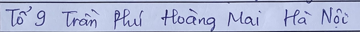

In [48]:
image = Image.open('i_3503.png').convert('RGB')
process_image = pre_process(image)
text = inference(process_image, model, vocab)
print(text)
ipd.display(image)